In [1]:
import tensorflow as tf, os, pandas as pd, numpy as np, pickle, glob
from sklearn.model_selection import KFold
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

2023-06-02 12:46:19.599733: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 12:46:19.736293: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-02 12:46:20.360021: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-02 12:46:20.360119: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
model_name_s = "mUSE" #ST-DBMCv1, ST-DBMCv2, USE
USD_data_test_pkl = glob.glob(f"./dataset/baseline-testdataset_pickle_save/sample_500_seed_42_feature/{model_name_s}_tf/*pkl")

In [3]:
import keras
def create_model(input_shape = (1024,)):
  model = tf.keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape = input_shape),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])
  return model

In [4]:
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
from tqdm import tqdm
def get_weight_path(fold, train_type):
    return './model_weight/PeriHD_and_IntraHD/weights_{}_KFold={}[{}neg+pos-05-17-full-text-experiment].h5'.format(model_name_s,fold,train_type)

def load_pkl(pkl):
    with open(pkl, 'rb') as f:
        pk_dict = pickle.load(f)
    return pk_dict

kfold = KFold(n_splits=5, shuffle=True)
train_type = model_name_s
input_shape  = (512,)
ths = 0.5
pred_dict ={'病人ID':[], '病人透析時間':[], '病人透析前血壓':[], 
            'sbp差(取最大值)':[], 'mbp差(取最大值)':[], 
            'NLP判斷結果(Y/N)':[], 'BP判斷結果(Y/N)':[],
            'IntraHD最高分斷句':[], 'PeriHD最高分斷句':[],
            'IntraHD預測分數':[], 'IntraHD真實答案':[],
            'PeriHD預測分數':[],'PeriHD真實答案':[],
            '當次IDH真實答案':[], '預期結果(Y/N)':[]}
count_peri = 0
count_intra = 0
for pkl_idx, next_test_pkl in tqdm(enumerate(USD_data_test_pkl), total=len(USD_data_test_pkl)):
        periHD_intraHD_dict = load_pkl(next_test_pkl)
        pred_dict['病人ID'].append(str(periHD_intraHD_dict['ID']))
        pred_dict['病人透析時間'].append(str(periHD_intraHD_dict['DateTime']))
        pred_dict['當次IDH真實答案'].append(periHD_intraHD_dict['IDH_answer'])
        pred_dict['PeriHD真實答案'].append(periHD_intraHD_dict['PeriHD_answer'])
        pred_dict['IntraHD真實答案'].append(periHD_intraHD_dict['IntraHD_answer'])
        # PeriHD Data
        PeriHD_sbp, PeriHD_dbp =  periHD_intraHD_dict['PeriHD_data_sbp'], periHD_intraHD_dict['PeriHD_data_dbp']
        pred_dict['病人透析前血壓'].append('{}/{}'.format(PeriHD_sbp, PeriHD_dbp))
        PeriHD_mbp = int((PeriHD_sbp+PeriHD_dbp)/2)
        PeriHD_context = periHD_intraHD_dict['PeriHD_context']
        PeriHD_Feature = periHD_intraHD_dict['PeriHD_Feature']
        count_peri+=1
        # IntraHD Data
        IntraHD_sbp, IntraHD_dbp =  periHD_intraHD_dict['IntraHD_data_sbp'], periHD_intraHD_dict['IntraHD_data_dbp']
        IntraHD_mbp = ((IntraHD_sbp+IntraHD_dbp)/2).astype(int)
        IntraHD_context = periHD_intraHD_dict['IntraHD_context']
        IntraHD_Feature = periHD_intraHD_dict['IntraHD_Feature']
        count_intra +=len(IntraHD_context)
        # 比較血壓是否有透析中低血壓
        
        max_difference_mbp = max(PeriHD_mbp-IntraHD_mbp)
        max_ifference_sbp = max(PeriHD_sbp-IntraHD_sbp)
        pred_dict['sbp差(取最大值)'].append(max_ifference_sbp)
        pred_dict['mbp差(取最大值)'].append(max_difference_mbp)
        bp_result = 'Y' if (max_difference_mbp>10) or (max_ifference_sbp>=20) else 'N'
        pred_dict['BP判斷結果(Y/N)'].append(bp_result)
        peri_predict_result=[0.0]*len(periHD_intraHD_dict['PeriHD_Feature'])
        intra_predict_result=[0.0]*len(periHD_intraHD_dict['IntraHD_Feature'])
        for fold in ['1','2','3','4','5']:
            # for fold in ['1','2','3','4','5']:
            weight_name = get_weight_path(fold, train_type)
            model_cls = create_model(input_shape=input_shape)
            model_cls.load_weights(weight_name)
            # nlp cls predict - periHD
            # periHD_text = np.expand_dims(periHD_intraHD_dict['PeriHD_Feature'],axis=0)
            peri_predict_result = peri_predict_result + model_cls.predict(periHD_intraHD_dict['PeriHD_Feature'], verbose=0).flatten()
            # nlp cls predict - intraHD
            intra_predict_result = intra_predict_result + model_cls.predict(periHD_intraHD_dict['IntraHD_Feature'], verbose=0).flatten()
        peri_predict_result = peri_predict_result/5
        intra_predict_result = intra_predict_result/5
        pred_dict['PeriHD預測分數'].append(round(max(peri_predict_result),4))
        pred_dict['PeriHD最高分斷句'].append(PeriHD_context[np.argmax(peri_predict_result)])

        pred_dict['IntraHD預測分數'].append(round(max(intra_predict_result),4))
        pred_dict['IntraHD最高分斷句'].append(IntraHD_context[np.argmax(intra_predict_result)])
        # 
        pred_dict['NLP判斷結果(Y/N)'].append('Y' if sum(peri_predict_result > ths)+sum(intra_predict_result > ths)!=0 else 'N')
        nlp_result = 'Y' if max(peri_predict_result)>0.5 or max(intra_predict_result)>0.5 else 'N'
        pred_dict['預期結果(Y/N)'].append('Y' if nlp_result==bp_result and bp_result=='Y' else 'N')

  0%|          | 0/497 [00:00<?, ?it/s]2023-06-02 12:46:21.963616: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 12:46:22.619025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22037 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:23:00.0, compute capability: 8.6
2023-06-02 12:46:23.921853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  0%|          | 1/497 [00:02<23:30,  2.84s/it]

100%|██████████| 497/497 [07:16<00:00,  1.14it/s]


In [5]:
pred_df = pd.DataFrame(pred_dict)

In [6]:
pred_PeriHD_answer = pred_df['PeriHD真實答案']
pred_PeriHD_predsc = pred_df['PeriHD預測分數']
pred_IntraHD_answer = pred_df['IntraHD真實答案']
pred_IntraHD_predsc = pred_df['IntraHD預測分數']
pred_IDH_answer = pred_df['當次IDH真實答案']

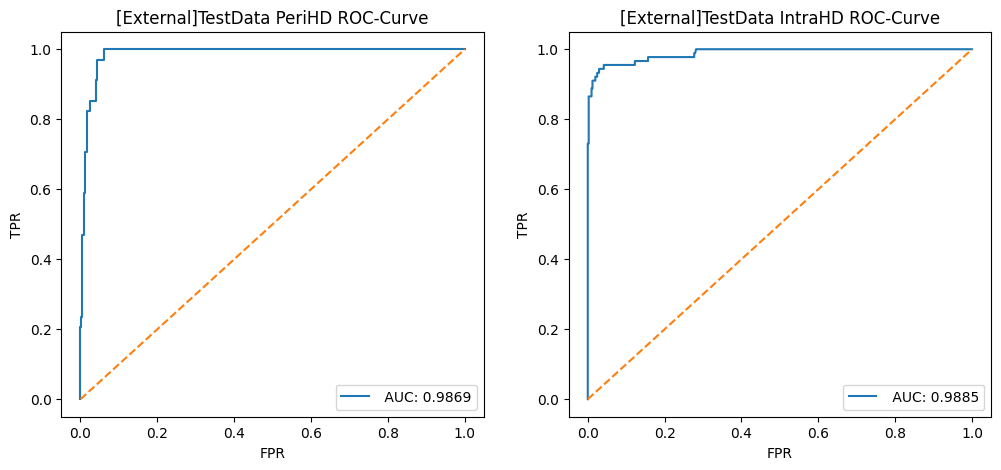

In [7]:
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fpr, tpr, thresholds = roc_curve(pred_PeriHD_answer, pred_PeriHD_predsc, pos_label=1)
auc = roc_auc_score(pred_PeriHD_answer, pred_PeriHD_predsc)
axs[0].plot(fpr, tpr, label = " AUC: {}".format(round(auc, 4)))
axs[0].plot([0,1],[0,1], linestyle='--')
axs[0].set_xlabel("FPR")
axs[0].set_ylabel("TPR")
axs[0].set_title(f"[External]TestData PeriHD ROC-Curve")
axs[0].legend()
peri_best_index = np.argmax(tpr-fpr)
peri_best_ths = thresholds[peri_best_index]
fpr, tpr, thresholds = roc_curve(pred_IntraHD_answer, pred_IntraHD_predsc, pos_label=1)
auc = roc_auc_score(pred_IntraHD_answer, pred_IntraHD_predsc)
axs[1].plot(fpr, tpr, label = " AUC: {}".format(round(auc, 4)))
axs[1].plot([0,1],[0,1], linestyle='--')
axs[1].set_xlabel("FPR")
axs[1].set_ylabel("TPR")
axs[1].set_title(f"[External]TestData IntraHD ROC-Curve")
axs[1].legend()
intra_best_index = np.argmax(tpr-fpr)
intra_best_ths = thresholds[peri_best_index]

In [8]:
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
# 已標記資料效能評估
def metric_calc(y_test, y_pred, ths=0.5):
    if ths!=None:
        y_pred = (y_pred>ths).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    sens = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn/(tn+fp)
    return acc, prec, sens, spec, f1, f"{tp} / {tn}",f"{fp} / {fn}"

def neg_pos_cross_table(ans, ped):
    new_comp = pd.DataFrame({'answer':ans,"predict":ped})
    new_comp['type'] = ['neg'if i ==0 else 'pos' for i in new_comp['answer']]
    new_comp_pos = new_comp[new_comp['type']=='pos']
    new_comp_neg = new_comp[new_comp['type']=='neg']
    return new_comp_pos, new_comp_neg
# ===========================
best_ths = (intra_best_ths+peri_best_ths)/2
# print(best_ths)
# thersholds = best_ths
thersholds = 0.5
PeriHD_metric = metric_calc(pred_df['PeriHD真實答案'],pred_df['PeriHD預測分數'], ths=thersholds)
IntraHD_metric = metric_calc(pred_df['IntraHD真實答案'], pred_df['IntraHD預測分數'], ths=thersholds)
IDH_truth = pred_df['當次IDH真實答案']
NLP_IDH_pred = [1 if max(p,i)>=thersholds else 0 for p,i in zip(pred_df['PeriHD預測分數'],pred_df['IntraHD預測分數'])]
IDH_metric = metric_calc(IDH_truth, NLP_IDH_pred, ths=None)
performace_table = pd.DataFrame(['Accuracy','Precision [macro]', 'Sensitivity [macro]', 'Specificity', 'F1-score [macro]', 'TP / TN', 'FP / FN'], columns=[f'TestData Metric[ths={thersholds}]'])
performace_table['PeriHD'] = PeriHD_metric
performace_table['IntraHD'] = IntraHD_metric
performace_table['IDH Judge'] = IDH_metric

In [9]:
performace_table

,TestData Metric[ths=0.5],PeriHD,IntraHD,IDH Judge
0,Accuracy,0.959759,0.947686,0.921529
1,Precision [macro],0.824027,0.892068,0.86987
2,Sensitivity [macro],0.910272,0.950567,0.922873
3,Specificity,0.967603,0.946078,0.920513
4,F1-score [macro],0.860878,0.917383,0.891962
5,TP / TN,29 / 448,85 / 386,99 / 359
6,FP / FN,15 / 5,22 / 4,31 / 8


In [14]:
pd.DataFrame(performace_table).to_csv(f'./ACM_{model_name_s}_performace_table_predict_test_sample500_intra+peri-ths{thersholds}_fulltext.csv', index=False, encoding='utf-8-sig')

In [15]:
pd.DataFrame(pred_dict).to_csv(f'./ACM_{model_name_s}_baseline_predict_test_sample500_intra+peri-ths{thersholds}_fulltext.csv', index=False, encoding='utf-8-sig')